In [1]:
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.service import Service

service = Service(GeckoDriverManager().install())
driver = webdriver.Firefox(service=service)

driver.get("https://finance.yahoo.com/quote/AAPL/history?p=AAPL")
print(driver.title)  

driver.quit()


Apple Inc. (AAPL) Stock Historical Prices & Data - Yahoo Finance


In [2]:
# VERSION 1 


service = Service(GeckoDriverManager().install())
driver = webdriver.Firefox(service=service)

driver.implicitly_wait(10)

url = "https://finance.yahoo.com/quote/AAPL/history/?p=AAPL&period1=1169683200&period2=1740498300"

driver.get(url)

# loaded?
print(driver.title)

# delay
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "table")))

while 1:
    try:
        show_more = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//button[text()="Show More"]'))
        )
        show_more.click()
        time.sleep(2)  
    except Exception as e:
        break

table = driver.find_element(By.TAG_NAME, "table")
rows = table.find_elements(By.TAG_NAME, "tr")

with open('yahoo_aapl.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    header = [th.text for th in rows[0].find_elements(By.TAG_NAME, "th")]
    writer.writerow(header)
    
    for row in rows[1:]:
        data = [td.text for td in row.find_elements(By.TAG_NAME, "td")]
        if len(data) == len(header):
            writer.writerow(data)

driver.quit()

Apple Inc. (AAPL) Stock Historical Prices & Data - Yahoo Finance


In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import csv
import re
import math
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.service import Service
from datetime import datetime

service = Service(GeckoDriverManager().install())
driver = webdriver.Firefox(service=service)
driver.implicitly_wait(10)

url = "https://finance.yahoo.com/quote/AAPL/history/?p=AAPL&period1=1169683200&period2=1740498300"
driver.get(url)
print("Page Title:", driver.title)

WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "table")))

# CLICK "SHOW MORE" REPEATEDLY TO LOAD ALL ROWS
while 1:
    try:
        show_more = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//button[text()="Show More"]'))
        )
        show_more.click()
        time.sleep(2)
    except Exception:
        break

# LOCATE TABLE AND ROWS
table = driver.find_element(By.TAG_NAME, "table")
rows = table.find_elements(By.TAG_NAME, "tr")

# HELPERS
def parse_date(date_str):
    """
    Converts a date string like "Feb 10, 2023" into a datetime object.
    """
    return datetime.strptime(date_str, "%b %d, %Y")

def to_float(val):
    """
    Safely converts a string to float, handling commas and empty strings.
    """
    if not val:
        return math.nan
    val = val.replace(',', '')
    try:
        return float(val)
    except:
        return math.nan

# DICTIONARY FOR MERGING ROWS BY DATE
# Key: datetime object
# Value: dict with all needed cols
data_by_date = {}

def init_date_dict(d):
    return {
        'Date': d,
        'Open': math.nan,
        'High': math.nan,
        'Low': math.nan,
        'Close': math.nan,
        'Adj Close': math.nan,
        'Volume': math.nan,
        'IsDividend': False,
        'DividendAmount': math.nan,
        'IsSplit': False,
        'SplitRatio': math.nan
    }

for row in rows[1:]:  # Skip header row
    data_cells = row.find_elements(By.TAG_NAME, "td")
    cell_count = len(data_cells)

    # Trading row typically has 7 columns
    if cell_count == 7:
        row_texts = [cell.text for cell in data_cells]
        date_str      = row_texts[0]
        open_val      = row_texts[1]
        high_val      = row_texts[2]
        low_val       = row_texts[3]
        close_val     = row_texts[4]
        adj_close_val = row_texts[5]
        volume_val    = row_texts[6]

        # Parse the date
        try:
            date_dt = parse_date(date_str)
        except:
            continue

        if date_dt not in data_by_date:
            data_by_date[date_dt] = init_date_dict(date_dt)

        data_by_date[date_dt]['Open']      = to_float(open_val)
        data_by_date[date_dt]['High']      = to_float(high_val)
        data_by_date[date_dt]['Low']       = to_float(low_val)
        data_by_date[date_dt]['Close']     = to_float(close_val)
        data_by_date[date_dt]['Adj Close'] = to_float(adj_close_val)
        data_by_date[date_dt]['Volume']    = to_float(volume_val)

    # Dividend or Split row typically has 2 columns
    elif cell_count == 2:
        row_texts = [cell.text for cell in data_cells]
        date_str  = row_texts[0]
        event_str = row_texts[1]  # For instance, "0.23 Dividend" or "4-for-1 Split"

        try:
            date_dt = parse_date(date_str)
        except:
            continue

        if date_dt not in data_by_date:
            data_by_date[date_dt] = init_date_dict(date_dt)

        # Check for Dividend
        if "Dividend" in event_str:
            data_by_date[date_dt]['IsDividend'] = True
            # Parse numeric portion, e.g. "0.23" in "0.23 Dividend"
            match_div = re.search(r'([\d.]+)\s*Dividend', event_str)
            if match_div:
                data_by_date[date_dt]['DividendAmount'] = to_float(match_div.group(1))

        # Check for Split
        elif "Split" in event_str:
            data_by_date[date_dt]['IsSplit'] = True
            # Parse out the first integer factor, e.g. "4" in "4-for-1 Split"
            match_split = re.search(r'(\d+)[^\d]*Split', event_str)
            if match_split:
                split_factor_str = match_split.group(1)
                data_by_date[date_dt]['SplitRatio'] = to_float(split_factor_str)

    else:
        continue

driver.quit()

# CONVERT DICTIONARY TO A SORTED LIST, THEN WRITE CSV
final_header = [
    'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'IsDividend', 'DividendAmount', 'IsSplit', 'SplitRatio'
]

# Sort by actual datetime
sorted_dates = sorted(data_by_date.keys())

with open('yahoo_aapl_merged.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(final_header)

    for d in sorted_dates:
        row_dict = data_by_date[d]
        writer.writerow([
            # Convert datetime back to string format 
            row_dict['Date'].strftime('%b %d, %Y'),
            row_dict['Open'],
            row_dict['High'],
            row_dict['Low'],
            row_dict['Close'],
            row_dict['Adj Close'],
            row_dict['Volume'],
            row_dict['IsDividend'],
            row_dict['DividendAmount'],
            row_dict['IsSplit'],
            row_dict['SplitRatio']
        ])

print(f"Successfully wrote {len(sorted_dates)} rows to yahoo_aapl_merged.csv")

Page Title: Apple Inc. (AAPL) Stock Historical Prices & Data - Yahoo Finance
Successfully wrote 4551 rows to yahoo_aapl_merged.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import math
import re
from datetime import datetime

df = pd.read_csv("yahoo_aapl_merged.csv")

print(df.head())

print("Shape:", df.shape)

print("Null Values:\n", df.isnull().sum())
print("Duplicate Rows:", df.duplicated().sum())

df.info()

           Date  Open  High   Low  Close  Adj Close       Volume  IsDividend  \
0  Jan 25, 2007  3.11  3.16  3.07   3.08       2.60  905973600.0       False   
1  Jan 26, 2007  3.11  3.12  3.04   3.05       2.57  986874000.0       False   
2  Jan 29, 2007  3.08  3.09  3.05   3.07       2.59  901664400.0       False   
3  Jan 30, 2007  3.09  3.09  3.04   3.06       2.57  577970400.0       False   
4  Jan 31, 2007  3.03  3.07  3.01   3.06       2.58  856069200.0       False   

   DividendAmount  IsSplit  SplitRatio  
0             NaN    False         NaN  
1             NaN    False         NaN  
2             NaN    False         NaN  
3             NaN    False         NaN  
4             NaN    False         NaN  
Shape: (4551, 11)
Null Values:
 Date                 0
Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
IsDividend           0
DividendAmount    4500
IsSplit              0
SplitRatio 

In [3]:
# Replace nulls in DividendAmount and SplitRatio with 0
df.fillna({'DividendAmount': 0, 'SplitRatio': 0}, inplace=True)

# Verify 
print("Null Values after fillna:\n", df.isnull().sum())

Null Values after fillna:
 Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
IsDividend        0
DividendAmount    0
IsSplit           0
SplitRatio        0
dtype: int64


In [4]:
# Convert Date to datetime, sort by date
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y', errors='coerce')
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Double-check
print("Start Date:", df.index.min())
print("End Date:", df.index.max())

Start Date: 2007-01-25 00:00:00
End Date: 2025-02-25 00:00:00


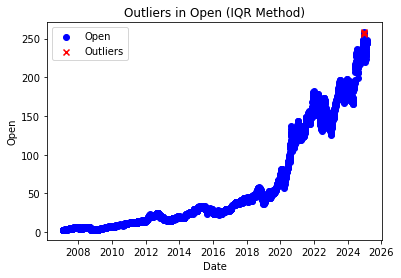

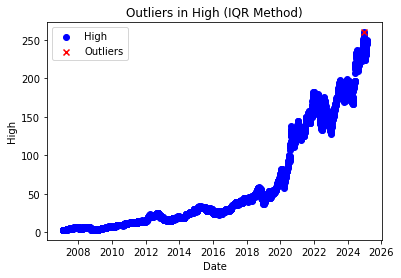

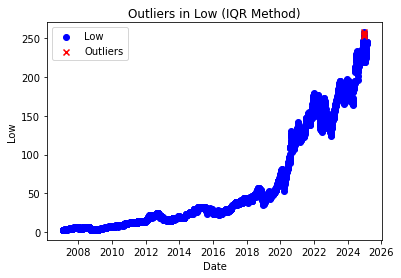

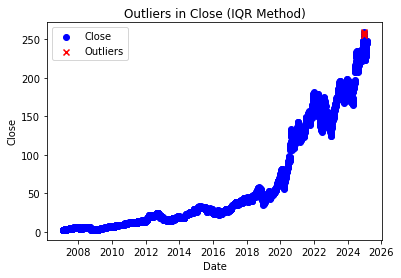

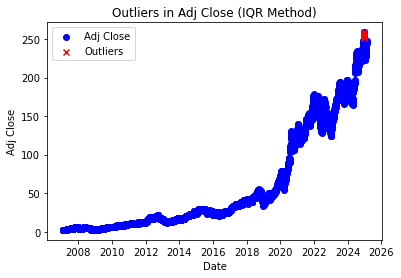

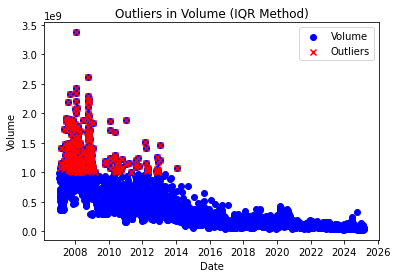

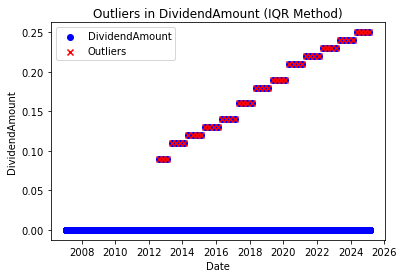

Column: Open, Outliers detected: 3
Column: High, Outliers detected: 1
Column: Low, Outliers detected: 4
Column: Close, Outliers detected: 4
Column: Adj Close, Outliers detected: 7
Column: Volume, Outliers detected: 278
Column: DividendAmount, Outliers detected: 51
Column: SplitRatio, Outliers detected: 2


In [5]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                'DividendAmount', 'SplitRatio']

outliers_dict = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers

    if col != "SplitRatio": # Already RARE
        plt.scatter(df.index, df[col], label=f"{col}", color="blue")
        plt.scatter(outliers.index, outliers[col], color="red", marker="x", label="Outliers")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.title(f"Outliers in {col} (IQR Method)")
        plt.legend()
        plt.show()


for col, outliers in outliers_dict.items():
    print(f"Column: {col}, Outliers detected: {len(outliers)}")

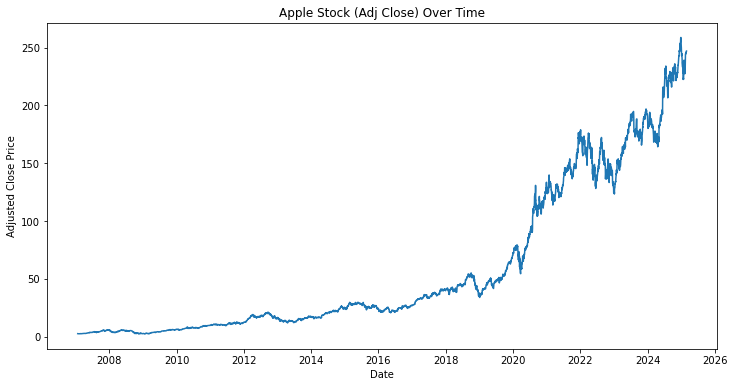

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='Adj Close', data=df)
plt.title("Apple Stock (Adj Close) Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.show()

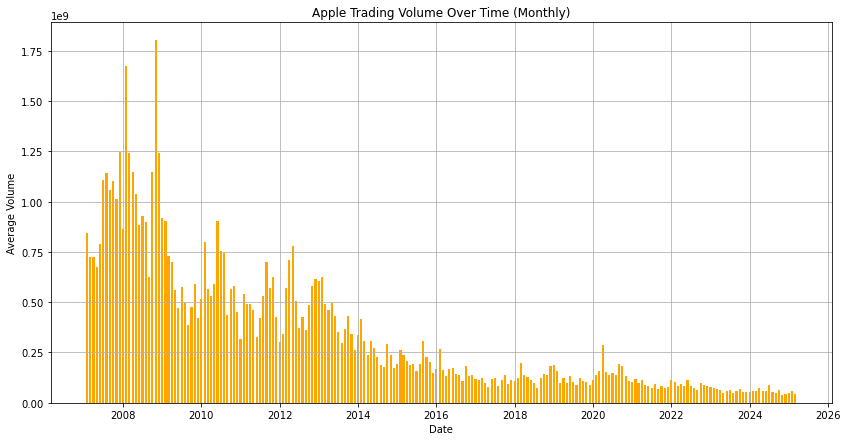

In [6]:
## How does the trading volume change over time?
import matplotlib.ticker as ticker
# Group by Month and calculate the average Volume
monthly_volume = df.resample('M')['Volume'].mean()

plt.figure(figsize=(14, 7))
plt.bar(monthly_volume.index, monthly_volume.values, width=20, color='orange')
plt.title('Apple Trading Volume Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Average Volume')
plt.grid(True)
plt.show()


# Great Recession 2008 indicated by a period of clear non-stability where the VOLUME 

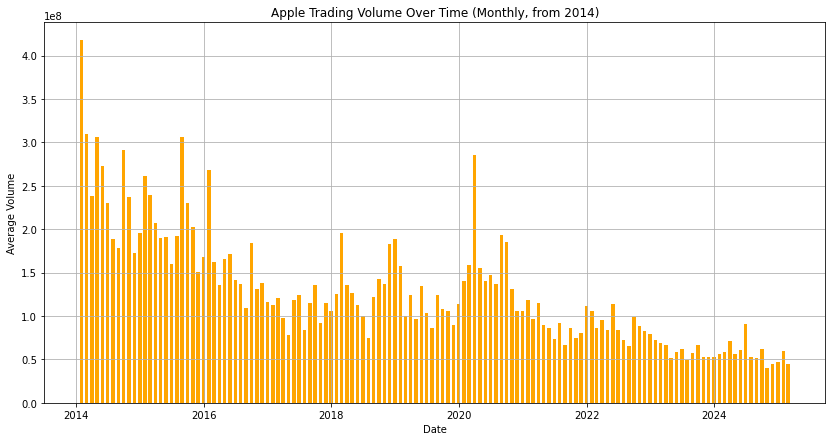

In [7]:
df_2014_onward = df.loc['2014-01-01':].copy()

# Group by month and calculate the average volume for each month
monthly_volume = df_2014_onward.resample('M')['Volume'].mean()

plt.figure(figsize=(14, 7))
plt.bar(monthly_volume.index, monthly_volume.values, width=20, color='orange')
plt.title('Apple Trading Volume Over Time (Monthly, from 2014)')
plt.xlabel('Date')
plt.ylabel('Average Volume')
plt.grid(True)
plt.show()

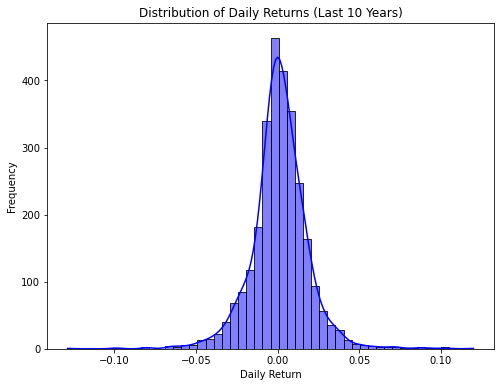

Daily Return Summary (Last 10 Years):
 count    2803.000000
mean        0.001105
std         0.017575
min        -0.128669
25%        -0.007058
50%         0.000946
75%         0.010108
max         0.119854
Name: DailyReturn, dtype: float64


In [8]:
df_last10 = df.loc['2014-01-01':].copy()

# Calculate daily returns based on Adjusted Close
df_last10['DailyReturn'] = df_last10['Adj Close'].pct_change()

# Plot the histogram with a KDE overlay for daily returns
plt.figure(figsize=(8, 6))
sns.histplot(df_last10['DailyReturn'].dropna(), bins=50, kde=True, color='blue')
plt.title("Distribution of Daily Returns (Last 10 Years)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

print("Daily Return Summary (Last 10 Years):\n", df_last10['DailyReturn'].describe())

# Mildly left skewed 
# Daily returns often fluctuate within +/- 1.7896% from the mean.
# This level of volatility is typical for large-cap tech stocks; it’s neither extremely low nor excessively high.
# Median very close to mean thus a symmetrical distribution, effective later in BOX PLOT

Highest (Adj Close): 258.74
Lowest (Adj Close): 15.55


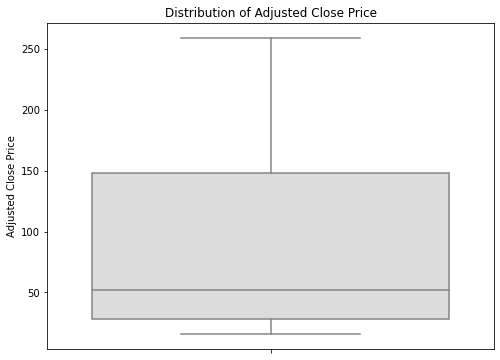

In [9]:
# Highest & Lowest Adjusted Close
df_2014_2025 = df.loc['2014-01-01':'2025-3-15'].copy()

highest_price = df_2014_2025['Adj Close'].max()
lowest_price = df_2014_2025['Adj Close'].min()

print(f"Highest (Adj Close): {highest_price:.2f}")
print(f"Lowest (Adj Close): {lowest_price:.2f}")

# Box Plot of Adjusted Close
plt.figure(figsize=(8, 6))
sns.boxplot(y='Adj Close', data=df_2014_2025, palette='coolwarm')
plt.title("Distribution of Adjusted Close Price")
plt.ylabel("Adjusted Close Price")
plt.show()

Highest (Adj Close) [2020-2025]: 258.74
Lowest (Adj Close) [2020-2025]: 54.45


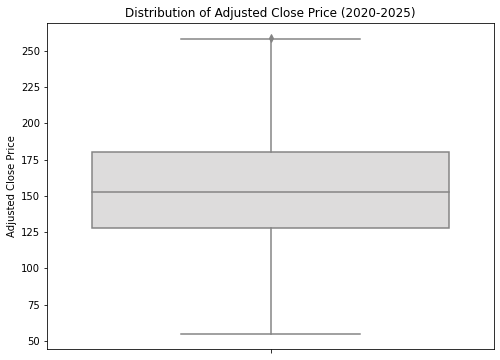

In [10]:
df_2020_2025 = df.loc['2020-01-01':'2025-3-15'].copy()

highest_price = df_2020_2025['Adj Close'].max()
lowest_price = df_2020_2025['Adj Close'].min()

print(f"Highest (Adj Close) [2020-2025]: {highest_price:.2f}")
print(f"Lowest (Adj Close) [2020-2025]: {lowest_price:.2f}")

plt.figure(figsize=(8, 6))
sns.boxplot(y='Adj Close', data=df_2020_2025, palette='coolwarm')
plt.title("Distribution of Adjusted Close Price (2020-2025)")
plt.ylabel("Adjusted Close Price")
plt.show()

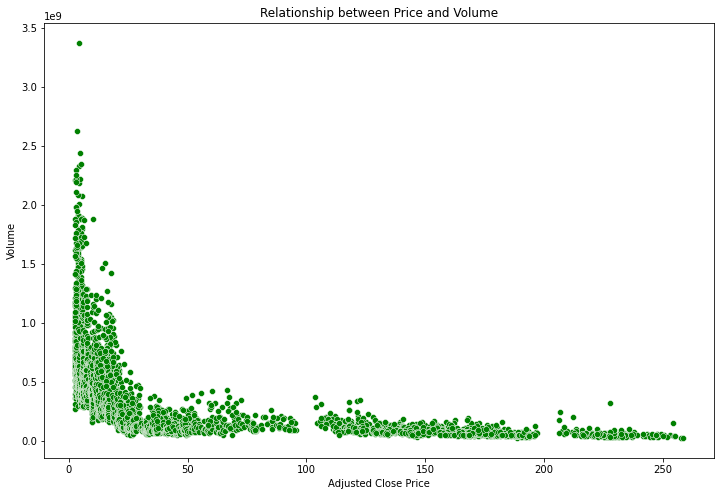

           Adj Close   Volume
Adj Close    1.00000 -0.52764
Volume      -0.52764  1.00000
Correlation between Adj Close and Volume: -0.5276


In [11]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Adj Close', y='Volume', data=df, color='green')
plt.title("Relationship between Price and Volume")
plt.xlabel("Adjusted Close Price")
plt.ylabel("Volume")
plt.show()

correlation = df[['Adj Close', 'Volume']].corr()
print(correlation)

correlation_value = df[['Adj Close', 'Volume']].corr().iloc[0,1]
print(f"Correlation between Adj Close and Volume: {correlation_value:.4f}")

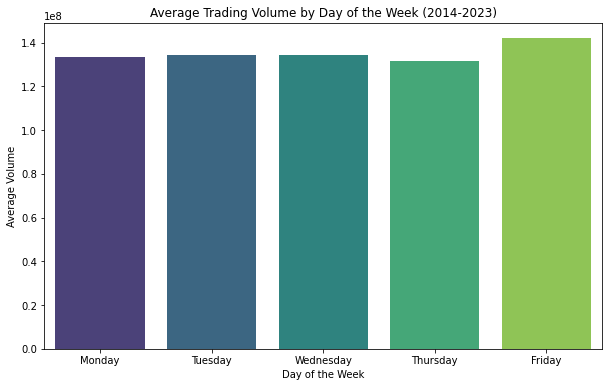

In [12]:
df_period = df.loc['2014-01-01':'2024-03-15'].copy()

df_period['DayOfWeek'] = df_period.index.day_name()

# Group by day of the week and calculate average Volume
volume_by_day = df_period.groupby('DayOfWeek')['Volume'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
)

plt.figure(figsize=(10, 6))
sns.barplot(x=volume_by_day.index, y=volume_by_day.values, palette='viridis')
plt.title("Average Trading Volume by Day of the Week (2014-2023)")
plt.xlabel("Day of the Week")
plt.ylabel("Average Volume")
plt.show()

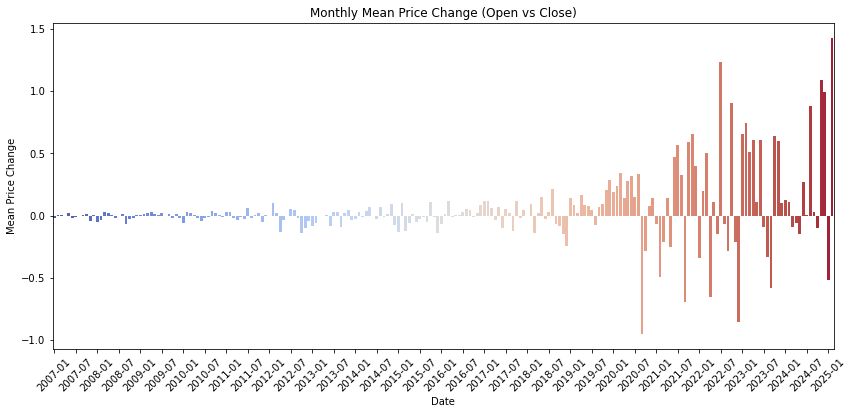

In [15]:
df['Daily Change'] = df['Close'] - df['Open']
monthly_change = df.resample('M')['Daily Change'].mean().rename_axis('Date').reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='Date', y='Daily Change', data=monthly_change, palette='coolwarm')
plt.title("Monthly Mean Price Change (Open vs Close)")
plt.xlabel("Date")
plt.ylabel("Mean Price Change")
ticks = range(0, len(monthly_change['Date']), 6)
tick_labels = monthly_change['Date'].dt.strftime('%Y-%m')[::6]
plt.xticks(ticks=ticks, labels=tick_labels, rotation=45)
plt.show()

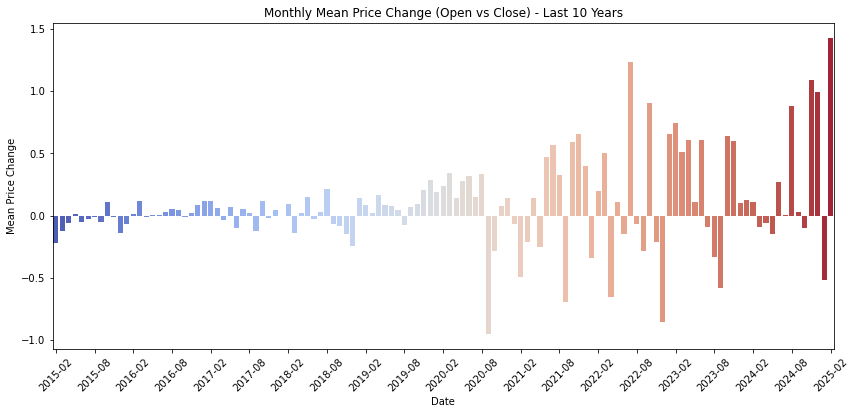

In [18]:
df['Daily Change'] = df['Close'] - df['Open']

cutoff_date = df.index.max() - pd.DateOffset(years=10)
df_last10 = df.loc[df.index >= cutoff_date].copy()

monthly_change = df_last10.resample('M')['Daily Change'].mean().rename_axis('Date').reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='Date', y='Daily Change', data=monthly_change, palette='coolwarm')
plt.title("Monthly Mean Price Change (Open vs Close) - Last 10 Years")
plt.xlabel("Date")
plt.ylabel("Mean Price Change")
ticks = range(0, len(monthly_change['Date']), 6)
tick_labels = monthly_change['Date'].dt.strftime('%Y-%m')[::6]
plt.xticks(ticks=ticks, labels=tick_labels, rotation=45)
plt.show()


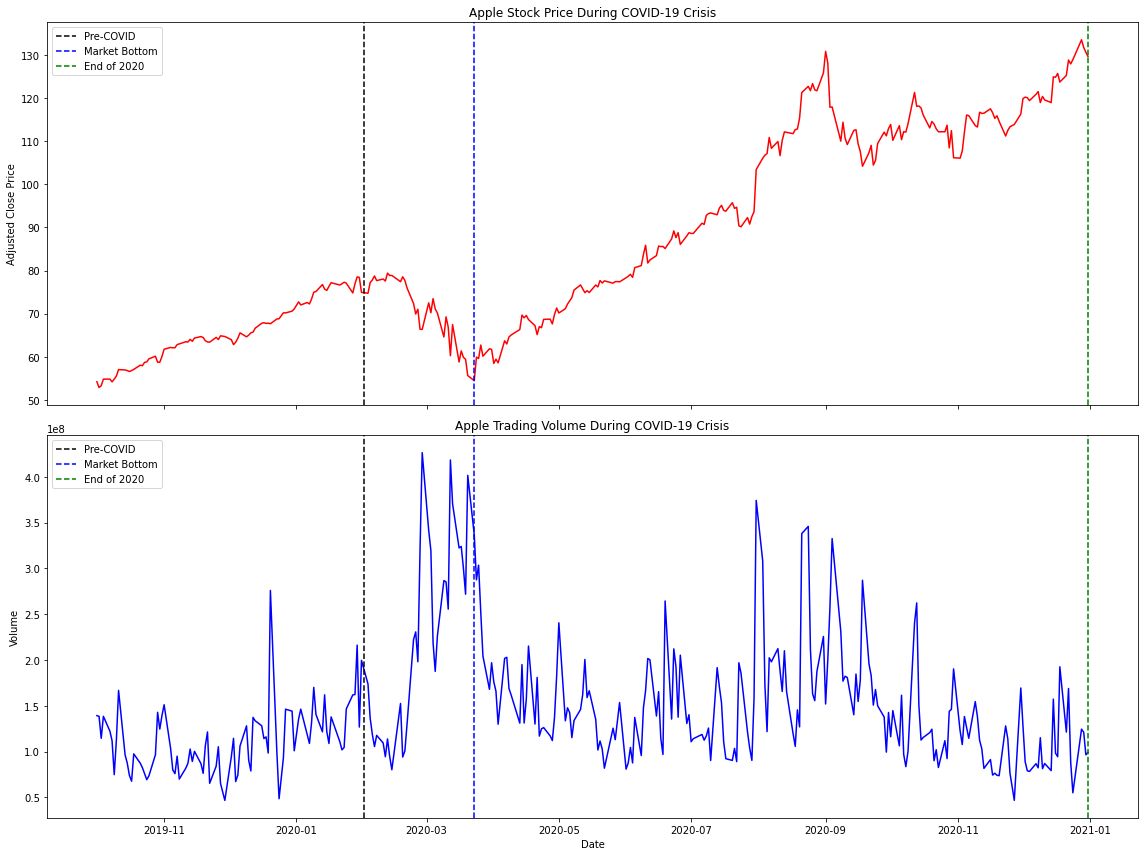

In [20]:
covid_period_extended = df.loc['2019-10-01':'2020-12-31'].copy()

fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

sns.lineplot(x=covid_period_extended.index, y='Adj Close', data=covid_period_extended, color='red', ax=ax[0])
ax[0].axvline(pd.Timestamp('2020-02-01'), color='black', linestyle='dashed', label='Pre-COVID')
ax[0].axvline(pd.Timestamp('2020-03-23'), color='blue', linestyle='dashed', label='Market Bottom')
ax[0].axvline(pd.Timestamp('2020-12-31'), color='green', linestyle='dashed', label='End of 2020')
ax[0].set_title("Apple Stock Price During COVID-19 Crisis")
ax[0].set_ylabel("Adjusted Close Price")
ax[0].legend()

sns.lineplot(x=covid_period_extended.index, y='Volume', data=covid_period_extended, color='blue', ax=ax[1])
ax[1].axvline(pd.Timestamp('2020-02-01'), color='black', linestyle='dashed', label='Pre-COVID')
ax[1].axvline(pd.Timestamp('2020-03-23'), color='blue', linestyle='dashed', label='Market Bottom')
ax[1].axvline(pd.Timestamp('2020-12-31'), color='green', linestyle='dashed', label='End of 2020')
ax[1].set_title("Apple Trading Volume During COVID-19 Crisis")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Date")
ax[1].legend()

plt.tight_layout()
plt.show()

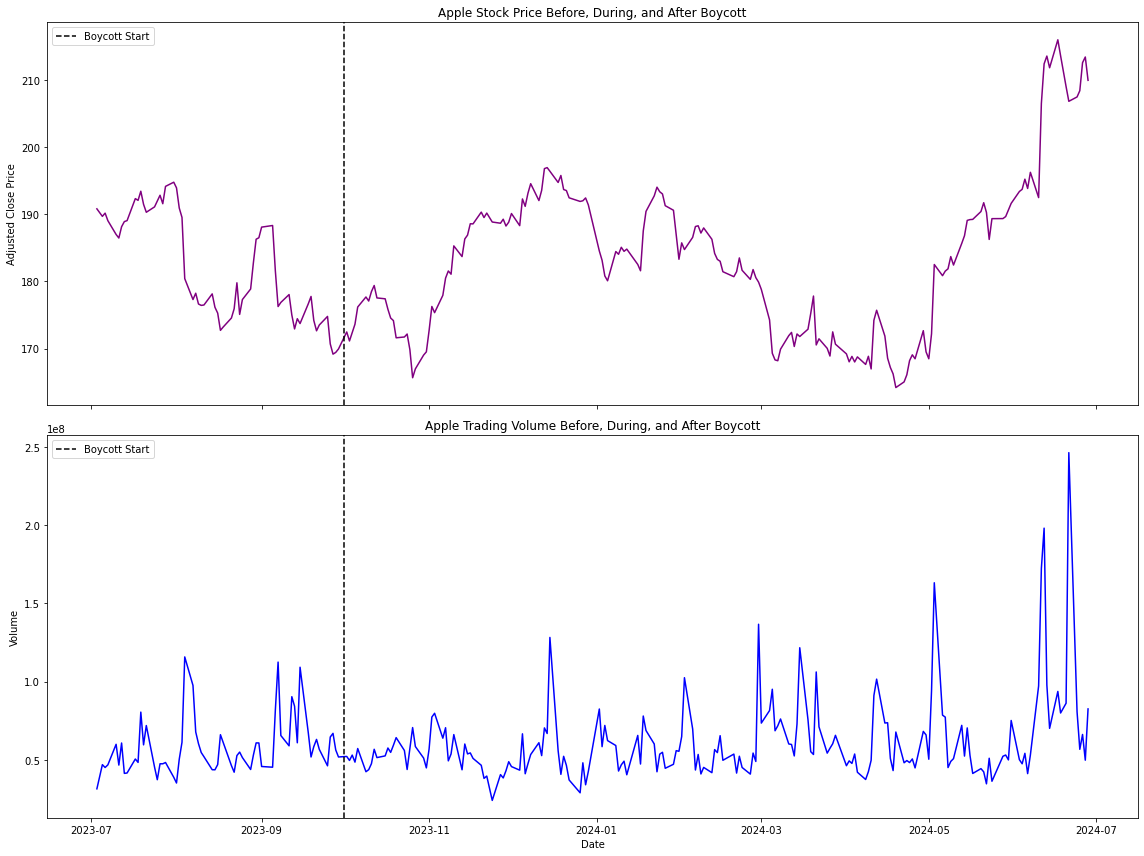

In [21]:
boycott_period = df.loc['2023-07-01':'2024-06-30'].copy()

fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

sns.lineplot(x=boycott_period.index, y='Adj Close', data=boycott_period, color='purple', ax=ax[0])
ax[0].axvline(pd.Timestamp('2023-10-01'), color='black', linestyle='dashed', label='Boycott Start')
ax[0].set_title("Apple Stock Price Before, During, and After Boycott")
ax[0].set_ylabel("Adjusted Close Price")
ax[0].legend()

sns.lineplot(x=boycott_period.index, y='Volume', data=boycott_period, color='blue', ax=ax[1])
ax[1].axvline(pd.Timestamp('2023-10-01'), color='black', linestyle='dashed', label='Boycott Start')
ax[1].set_title("Apple Trading Volume Before, During, and After Boycott")
ax[1].set_ylabel("Volume")
ax[1].set_xlabel("Date")
ax[1].legend()

plt.tight_layout()
plt.show()

Total Dividend Dates: 51
            DividendAmount
Date                      
2012-08-09            0.09
2012-11-07            0.09
2013-02-07            0.09
2013-05-09            0.11
2013-08-08            0.11
2013-11-06            0.11
2014-02-06            0.11
2014-05-08            0.12
2014-08-07            0.12
2014-11-06            0.12


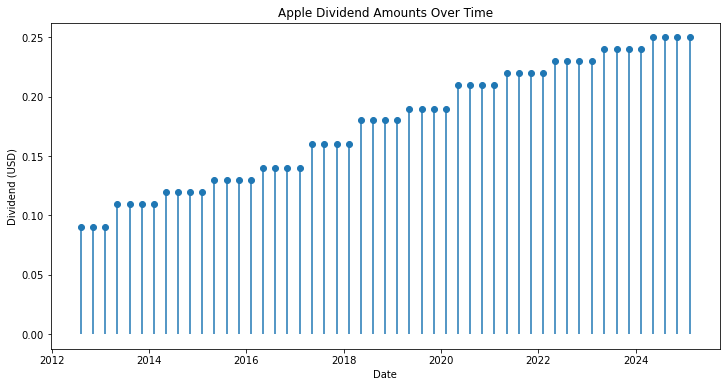

In [22]:
dividend_df = df[df['IsDividend'] == True].copy()
print("Total Dividend Dates:", len(dividend_df))
print(dividend_df[['DividendAmount']].head(10))

plt.figure(figsize=(12, 6))
plt.stem(dividend_df.index, dividend_df['DividendAmount'], basefmt=" ")
plt.title("Apple Dividend Amounts Over Time")
plt.xlabel("Date")
plt.ylabel("Dividend (USD)")
plt.show()

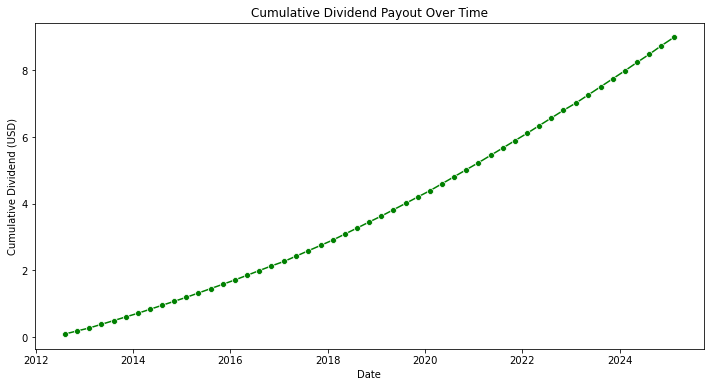

In [23]:
dividend_df['CumulativeDividend'] = dividend_df['DividendAmount'].cumsum()

plt.figure(figsize=(12, 6))
sns.lineplot(data=dividend_df, x=dividend_df.index, y='CumulativeDividend', marker='o', color='green')
plt.title("Cumulative Dividend Payout Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Dividend (USD)")
plt.show()

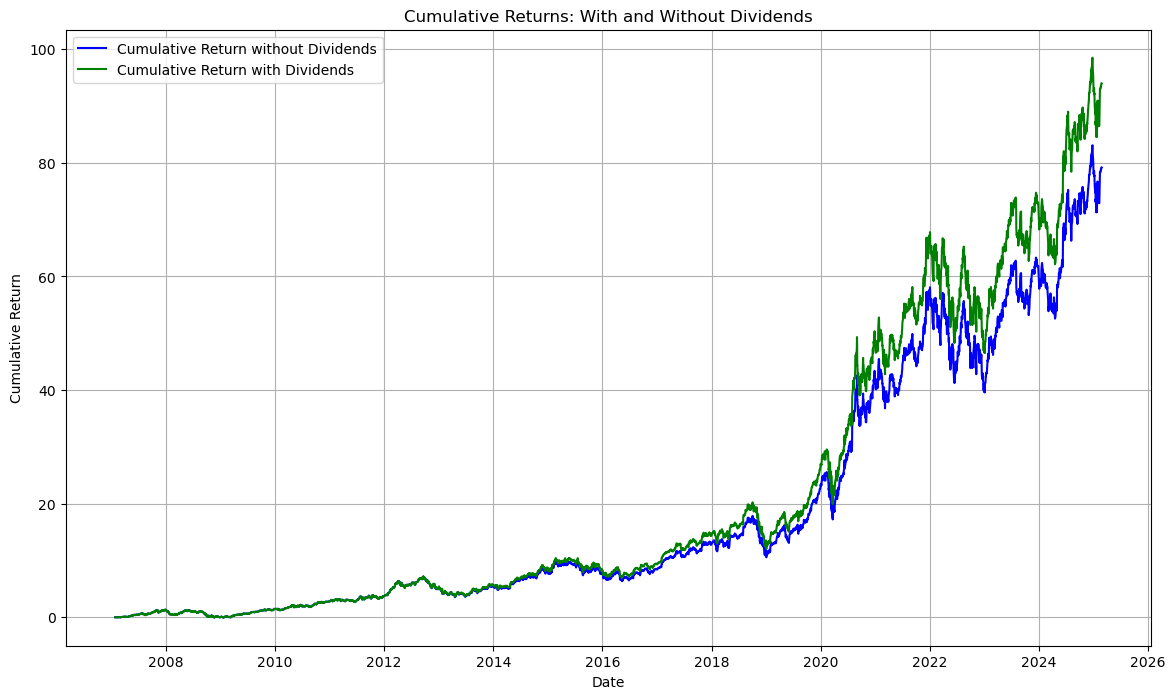

In [37]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y', errors='coerce')
    df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Calculate daily returns using Close (price appreciation only)
df['Return_without_div'] = df['Close'].pct_change()
df['Cumulative_Return_without_div'] = (1 + df['Return_without_div']).cumprod() - 1

# Calculate daily returns using Adj Close (total return: price appreciation + dividends)
df['Return_with_div'] = df['Adj Close'].pct_change()
df['Cumulative_Return_with_div'] = (1 + df['Return_with_div']).cumprod() - 1

plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Cumulative_Return_without_div'], label='Cumulative Return without Dividends', color='blue')
plt.plot(df.index, df['Cumulative_Return_with_div'], label='Cumulative Return with Dividends', color='green')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns: With and Without Dividends")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#df['DividendYield'] = np.where(df['IsDividend'], df['DividendAmount'] / df['Close'], 0)


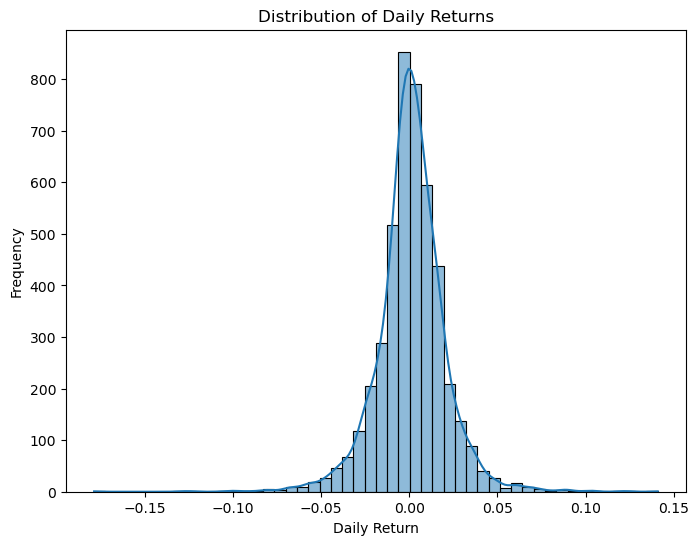

Daily Return Summary:
 count    4550.000000
mean        0.001195
std         0.019658
min        -0.178756
25%        -0.007843
50%         0.001172
75%         0.011368
max         0.140893
Name: DailyReturn, dtype: float64


In [34]:
df['DailyReturn'] = df['Adj Close'].pct_change()

plt.figure(figsize=(8, 6))
sns.histplot(df['DailyReturn'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

print("Daily Return Summary:\n", df['DailyReturn'].describe())

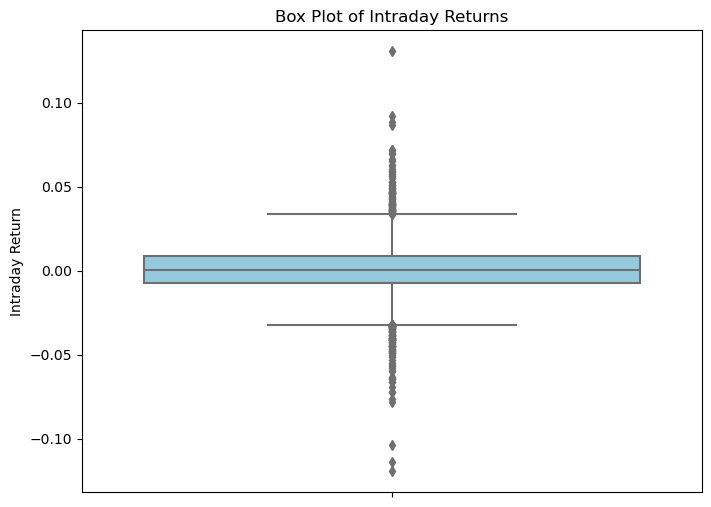

Intraday Return Summary:
 count    4551.000000
mean        0.000359
std         0.015937
min        -0.119438
25%        -0.007529
50%         0.000521
75%         0.008938
max         0.130719
Name: IntradayReturn, dtype: float64


In [35]:
df['IntradayReturn'] = (df['Close'] - df['Open']) / df['Open']

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['IntradayReturn'], color='skyblue')
plt.title("Box Plot of Intraday Returns")
plt.ylabel("Intraday Return")
plt.show()

print("Intraday Return Summary:\n", df['IntradayReturn'].describe())

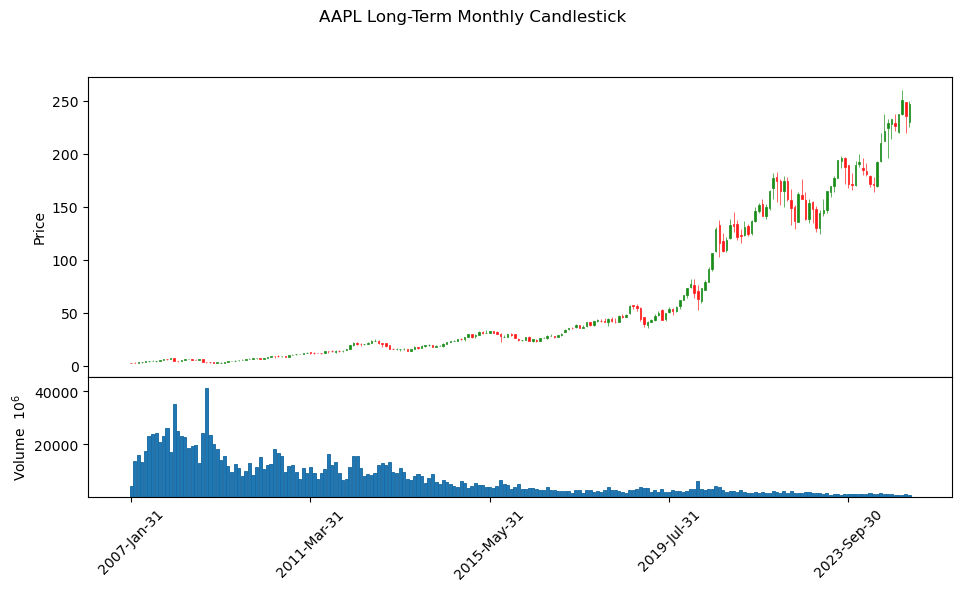

In [24]:
# Resample to monthly OHLC
df_monthly = df.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

mc = mpf.make_marketcolors(up='g', down='r', edge='inherit', wick='inherit')
style = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(
    df_monthly,
    type='candle',
    style=style,
    title='AAPL Long-Term Monthly Candlestick',
    volume=True,
    figsize=(12, 6),
    ylabel='Price'
)

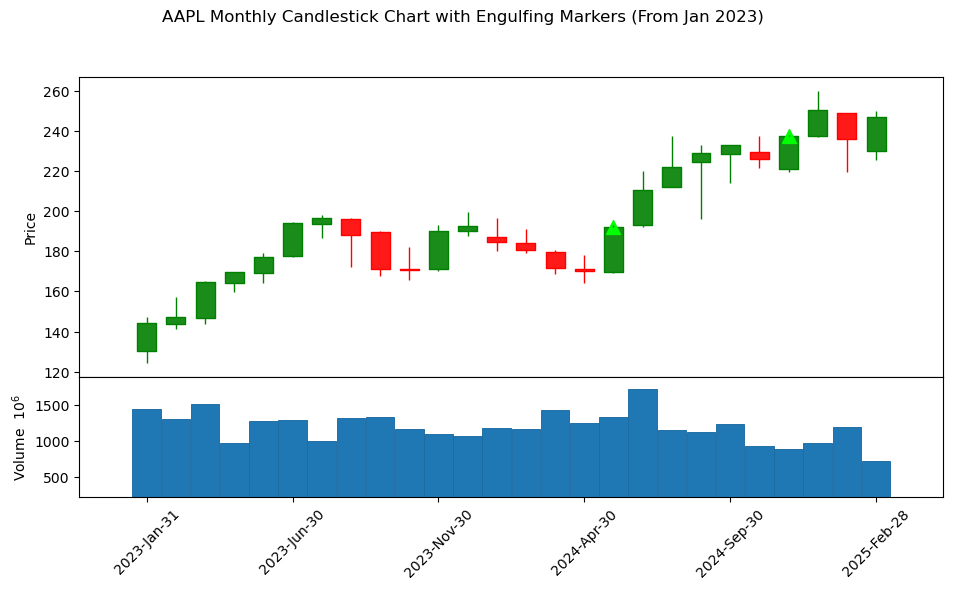

In [33]:
df_monthly = df.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

df_monthly = df_monthly.loc['2023-01-01':]

# Detect engulfing patterns on the monthly data
df_monthly['BullishEngulf'] = False
df_monthly['BearishEngulf'] = False

for i in range(1, len(df_monthly)):
    prev_open = df_monthly.iloc[i-1]['Open']
    prev_close = df_monthly.iloc[i-1]['Close']
    curr_open = df_monthly.iloc[i]['Open']
    curr_close = df_monthly.iloc[i]['Close']

    prev_green = (prev_close > prev_open)
    curr_green = (curr_close > curr_open)

    if (not prev_green) and curr_green:
        if (curr_open < prev_close) and (curr_close > prev_open):
            df_monthly.iloc[i, df_monthly.columns.get_loc('BullishEngulf')] = True

    if prev_green and (not curr_green):
        if (curr_open > prev_close) and (curr_close < prev_open):
            df_monthly.iloc[i, df_monthly.columns.get_loc('BearishEngulf')] = True

# Prepare marker series using .where() to keep only the closing price on engulfing candles
bullish_series = df_monthly['Close'].where(df_monthly['BullishEngulf'], np.nan)
bearish_series = df_monthly['Close'].where(df_monthly['BearishEngulf'], np.nan)

add_plots = []
if bullish_series.notna().any():
    add_plots.append(mpf.make_addplot(bullish_series, type='scatter', marker='^', color='lime', markersize=100))
if bearish_series.notna().any():
    add_plots.append(mpf.make_addplot(bearish_series, type='scatter', marker='v', color='red', markersize=100))

# Create a custom market color style
mc2 = mpf.make_marketcolors(up='g', down='r', edge='inherit', wick='inherit')
style2 = mpf.make_mpf_style(marketcolors=mc2)

# Plot the monthly candlestick chart with engulfing markers
mpf.plot(
    df_monthly,
    type='candle',
    style=style2,
    volume=True,
    addplot=add_plots,
    title='AAPL Monthly Candlestick Chart with Engulfing Markers (From Jan 2023)',
    figsize=(12, 6)
)

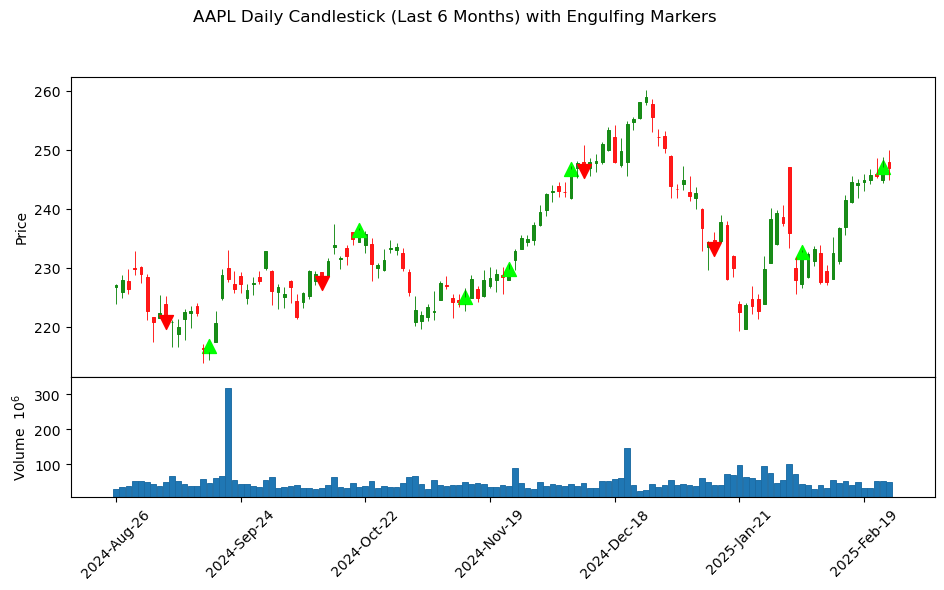

In [29]:
# Last 6 Months
cutoff_date = df.index.max() - pd.DateOffset(months=6)
df_short = df.loc[df.index >= cutoff_date].copy()

# Detect Engulfing Candles
# Bullish Engulfing: Current day's body (Close - Open) fully engulfs previous day's body, and direction changes from down to up
# Bearish Engulfing: Opposite scenario

df_short['BullishEngulf'] = False
df_short['BearishEngulf'] = False

for i in range(1, len(df_short)):
    prev_open = df_short.iloc[i-1]['Open']
    prev_close = df_short.iloc[i-1]['Close']
    curr_open = df_short.iloc[i]['Open']
    curr_close = df_short.iloc[i]['Close']

    # Determine if previous candle was green (up) or red (down)
    prev_green = (prev_close > prev_open)
    curr_green = (curr_close > curr_open)

    # Bullish engulfing: previous candle red, current green,
    # and current day's body fully engulfs the previous day's body
    if (not prev_green) and curr_green:
        if (curr_open < prev_close) and (curr_close > prev_open):
            df_short.iloc[i, df_short.columns.get_loc('BullishEngulf')] = True

    # Bearish engulfing: previous candle green, current red,
    # and current day's body fully engulfs the previous day's body
    if prev_green and (not curr_green):
        if (curr_open > prev_close) and (curr_close < prev_open):
            df_short.iloc[i, df_short.columns.get_loc('BearishEngulf')] = True

# Prepare Series for Engulfing Markers using .where() to keep only relevant values
bullish_series = df_short['Close'].where(df_short['BullishEngulf'], np.nan)
bearish_series = df_short['Close'].where(df_short['BearishEngulf'], np.nan)

# Plot daily candlesticks with engulfing markers
mc2 = mpf.make_marketcolors(up='g', down='r', edge='inherit', wick='inherit')
style2 = mpf.make_mpf_style(marketcolors=mc2)

df_short_ohlc = df_short[['Open','High','Low','Close','Volume']].copy()

# MARKERS
add_plots = [
    mpf.make_addplot(bullish_series, type='scatter', marker='^', color='lime', markersize=100),
    mpf.make_addplot(bearish_series, type='scatter', marker='v', color='red', markersize=100)
]

mpf.plot(
    df_short_ohlc,
    type='candle',
    style=style2,
    volume=True,
    addplot=add_plots,
    title='AAPL Daily Candlestick (Last 6 Months) with Engulfing Markers',
    figsize=(12, 6)
)

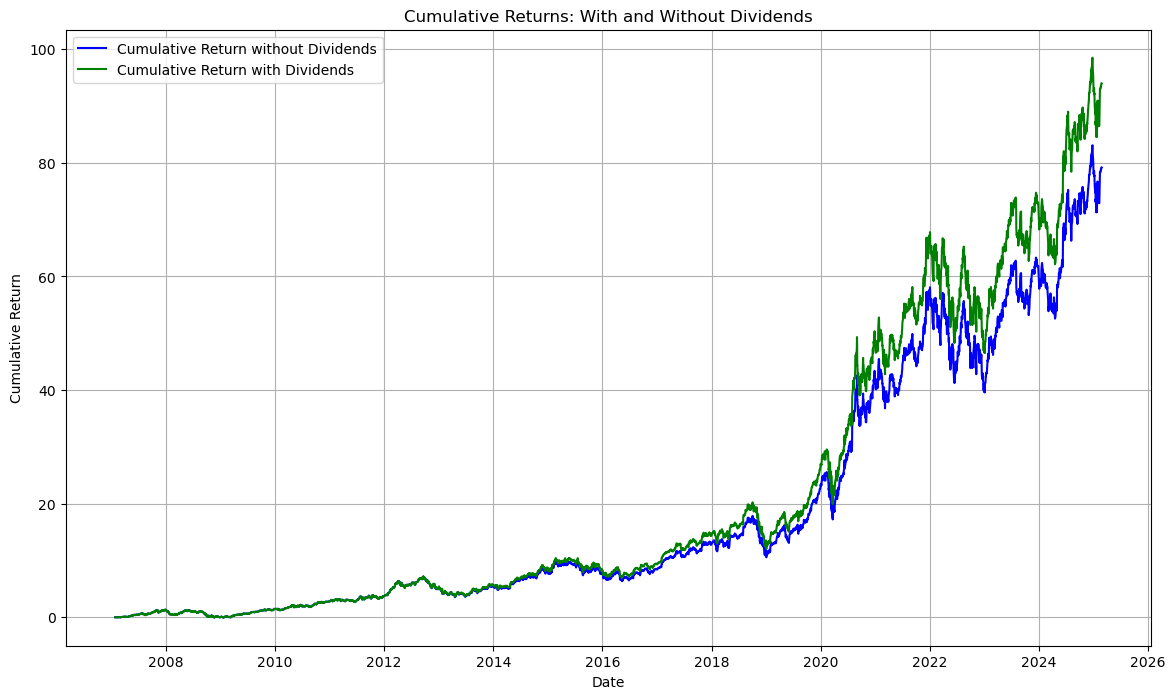

# BTWADENE W TGEBNY DAAART EL 3'ASALA